## Compare dim vs non-dim models

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-01-27 18:27:05.666739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-27 18:27:05.688972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-27 18:27:05.696617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
experiment_config_nondim = {'experiment_name': 'DG_3_non_dim', # Any sort of name will work here 
                    'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':3, 
                    
                    'input_channels' : ['dudx_widened_nondim',  
                                        'dvdx_widened_nondim', 
                                        'dudy_widened_nondim',
                                        'dvdy_widened_nondim',
                                        'dhdx_widened',
                                        'dhdy_widened'],
                    
                    'output_channels' : ['uphp_nondim',
                                         'vphp_nondim'],
                    
                    'coeff_channels'  : [], 
                    
                    'extra_channels': ['filter_scale',
                                       'mag_nabla_u_widened',
                                       'uphp',
                                       'vphp'],

                    'all_time_range': slice(0, 1400), 
                    'train_time_range': slice(0, 1200),
                    'test_time_range' : slice(-100, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 
                   
                    'network_shape': [36, 36, 2],
                    'single_layer_mask': True}

experiment_config_nondim['all_ml_variables'] = (experiment_config_nondim['input_channels'] + 
                                           experiment_config_nondim['output_channels'] +
                                           experiment_config_nondim['coeff_channels']+ 
                                           experiment_config_nondim['extra_channels'])

experiment_config_nondim['exp_ckpt_save_dir'] = ('/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/non_dim_models/' + 
                                          experiment_config_nondim['experiment_name'] ) 

In [5]:
experiment_config_dim = {'experiment_name': 'DG_3_dim', # Any sort of name will work here 
                    'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':3, 
                    
                    'input_channels' : ['dudx_widened',  
                                        'dvdx_widened', 
                                        'dudy_widened',
                                        'dvdy_widened',
                                        'dhdx_widened',
                                        'dhdy_widened',
                                        'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 
                    
                    'extra_channels': [],

                    'all_time_range': slice(0, 1400), 
                    'train_time_range': slice(0, 1200),
                    'test_time_range' : slice(-100, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 
                   
                    'network_shape': [36, 36, 2],
                    'single_layer_mask': True}

experiment_config_dim['all_ml_variables'] = (experiment_config_dim['input_channels'] + 
                                           experiment_config_dim['output_channels'] +
                                           experiment_config_dim['coeff_channels']+ 
                                           experiment_config_dim['extra_channels'])

experiment_config_dim['exp_ckpt_save_dir'] = ('/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/dim_models/' + 
                                          experiment_config_dim['experiment_name'] ) 

In [6]:
experiment_config_dim['num_inputs'] = 55
experiment_config_nondim['num_inputs'] = 54

In [7]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config_nondim['simulation_names'], 
                             filter_scales=experiment_config_nondim['filter_scales'], 
                             window_size = experiment_config_nondim['window_size'],
                             time_sel = experiment_config_nondim['all_time_range'],
                             single_layer_mask=experiment_config_nondim['single_layer_mask'])

## Training

In [8]:
ML_DT_train_nondim = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config_nondim['all_ml_variables'],
                                       time_range=experiment_config_nondim['train_time_range'],
                                       num_batches = experiment_config_nondim['num_train_batches'])

ML_DT_test_nondim = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config_nondim['all_ml_variables'],
                                      time_range=experiment_config_nondim['test_time_range'],
                                      num_batches = experiment_config_nondim['num_test_batches'])

Will load : 3.28704 gb into memory.
load took: 109.6088 seconds
Will load : 0.27392 gb into memory.
load took: 9.5815 seconds


In [10]:
ML_DT_train_dim = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config_dim['all_ml_variables'],
                                       time_range=experiment_config_dim['train_time_range'],
                                       num_batches = experiment_config_dim['num_train_batches'])

ML_DT_test_dim = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config_dim['all_ml_variables'],
                                      time_range=experiment_config_dim['test_time_range'],
                                      num_batches = experiment_config_dim['num_test_batches'])

Will load : 3.13296 gb into memory.
load took: 72.6734 seconds
Will load : 0.26108 gb into memory.
load took: 6.5714 seconds


In [11]:
normalize_data_dic={
    'dudx_widened_nondim': ([], 1.),  # scalar value
    'dvdx_widened_nondim': ([], 1.),
    'dudy_widened_nondim': ([], 1.),
    'dvdy_widened_nondim': ([], 1.),

    'dhdx_widened': ([], 1e-4),
    'dhdy_widened': ([], 1e-4),

    'dudx_widened': ([], 1e-7),  # scalar value
    'dvdx_widened': ([], 1e-7),
    'dudy_widened': ([], 1e-7),
    'dvdy_widened': ([], 1e-7),

    'Rd_nondim': ([], 1.),
    'filter_scale': ([], 140e3),
    
    'uphp_nondim': ([], 1e-5),
    'vphp_nondim': ([], 1e-5),
    'uphp': ([], .4),
    'vphp': ([], .4)}

ds_norm = xr.Dataset(normalize_data_dic)

In [12]:
train_ML_data_dim = datasets.MLJAXDataset(ML_DT_train_dim, 
                                      input_channels=experiment_config_dim['input_channels'], 
                                      output_channels=experiment_config_dim['output_channels'], 
                                      coeff_channels=experiment_config_dim['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data_dim = datasets.MLJAXDataset(ML_DT_test_dim, 
                                      input_channels=experiment_config_dim['input_channels'], 
                                      output_channels=experiment_config_dim['output_channels'], 
                                      coeff_channels=experiment_config_dim['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo_dim = {'train_data':train_ML_data_dim, 'test_data':test_ML_data_dim}

In [13]:
train_ML_data_nondim = datasets.MLJAXDataset(ML_DT_train_nondim, 
                                      input_channels=experiment_config_nondim['input_channels'], 
                                      output_channels=experiment_config_nondim['output_channels'], 
                                      coeff_channels=experiment_config_nondim['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data_nondim = datasets.MLJAXDataset(ML_DT_test_nondim, 
                                      input_channels=experiment_config_nondim['input_channels'], 
                                      output_channels=experiment_config_nondim['output_channels'], 
                                      coeff_channels=experiment_config_nondim['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo_nondim = {'train_data':train_ML_data_nondim, 'test_data':test_ML_data_nondim}

In [14]:
ANN_model_nondim = ML_classes.PointwiseANN(num_in = experiment_config_nondim['num_inputs'],
                                    shape = experiment_config_nondim['network_shape']) 

In [15]:
ANN_model_nondim.count_parameters()

3386


In [16]:
regress_sys_nondim = ML_classes.AnnRegressionSystem(ANN_model_nondim)

In [17]:
%%time 
regress_sys_nondim.train_system(ML_data_combo_nondim, num_epoch=101, print_freq=2, use_wandb=False)

At epoch 1. Train loss :  0.8552992553324312 , Test loss: 0.6301281094551087 , Test R2: -0.8761463642120362
At epoch 3. Train loss :  0.39132001915493525 , Test loss: 0.3832213461399078 , Test R2: -0.14091365337371825
At epoch 5. Train loss :  0.3236613958268552 , Test loss: 0.3288406431674957 , Test R2: 0.020996367931365965
At epoch 7. Train loss :  0.2927402193481858 , Test loss: 0.3017975986003876 , Test R2: 0.1015114426612854
At epoch 9. Train loss :  0.2723307045730385 , Test loss: 0.2822843134403229 , Test R2: 0.15961278676986695
At epoch 11. Train loss :  0.2593517722310247 , Test loss: 0.2757165372371674 , Test R2: 0.1791451930999756
At epoch 13. Train loss :  0.2509019113070256 , Test loss: 0.26141804456710815 , Test R2: 0.2217360258102417
At epoch 15. Train loss :  0.24297412827208237 , Test loss: 0.25658969581127167 , Test R2: 0.2360992431640625
At epoch 17. Train loss :  0.23814726318861987 , Test loss: 0.25078727304935455 , Test R2: 0.25336875915527346
At epoch 19. Train l

In [18]:
ANN_model_dim = ML_classes.PointwiseANN(num_in = experiment_config_dim['num_inputs'],
                                    shape = experiment_config_dim['network_shape']) 

regress_sys_dim = ML_classes.AnnRegressionSystem(ANN_model_dim)

In [19]:
%%time 
regress_sys_dim.train_system(ML_data_combo_dim, num_epoch=101, print_freq=2, use_wandb=False)

At epoch 1. Train loss :  1.6609539405719653 , Test loss: 1.1478662014007568 , Test R2: -0.985244631767273
At epoch 3. Train loss :  0.8770640170252001 , Test loss: 0.8760308027267456 , Test R2: -0.5150336265563965
At epoch 5. Train loss :  0.7322100739221316 , Test loss: 0.7523136734962463 , Test R2: -0.30108702182769775
At epoch 7. Train loss :  0.656408074739817 , Test loss: 0.6789349913597107 , Test R2: -0.17425096035003662
At epoch 9. Train loss :  0.6097338972864924 , Test loss: 0.6363261103630066 , Test R2: -0.10058186054229737
At epoch 11. Train loss :  0.5592950501957455 , Test loss: 0.59080570936203 , Test R2: -0.021834635734558107
At epoch 13. Train loss :  0.5335480216387156 , Test loss: 0.5685657382011413 , Test R2: 0.016627585887908934
At epoch 15. Train loss :  0.5023303990428513 , Test loss: 0.5407339692115783 , Test R2: 0.06476531028747559
At epoch 17. Train loss :  0.47752081542401703 , Test loss: 0.5183912515640259 , Test R2: 0.1034553050994873
At epoch 19. Train los

In [20]:
experiment_config_nondim['exp_ckpt_save_dir']

'/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/non_dim_models/DG_3_non_dim'

In [21]:
regress_sys_nondim.save_checkpoint(experiment_config_nondim['exp_ckpt_save_dir'], overwrite=True)
regress_sys_dim.save_checkpoint(experiment_config_dim['exp_ckpt_save_dir'])

In [22]:
test_eval_nondim = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config_nondim['input_channels'],
                                 output_channels=experiment_config_nondim['output_channels'], 
                                 coeff_channels=experiment_config_nondim['coeff_channels'], 
                                 extra_channels=experiment_config_nondim['extra_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config_nondim['num_inputs'], 
                                 shape=experiment_config_nondim['network_shape'], 
                                 ckpt_dir=experiment_config_nondim['exp_ckpt_save_dir'])

# Spin up eval pack
test_eval_nondim.read_ann_regression_model()
test_eval_nondim.read_eval_data()
test_eval_nondim.predict()

In [23]:
test_eval_nondim.dimensionalize()

In [24]:
test_eval_dim = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config_dim['input_channels'],
                                 output_channels=experiment_config_dim['output_channels'], 
                                 coeff_channels=experiment_config_dim['coeff_channels'], 
                                 extra_channels=experiment_config_dim['extra_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config_dim['num_inputs'], 
                                 shape=experiment_config_dim['network_shape'], 
                                 ckpt_dir=experiment_config_dim['exp_ckpt_save_dir'])

# Spin up eval pack
test_eval_dim.read_ann_regression_model()
test_eval_dim.read_eval_data()
test_eval_dim.predict()

In [25]:
test_eval_dim.calc_time_hor_space_metrics(var='uphp', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval_dim.calc_time_hor_space_metrics(var='vphp', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


test_eval_dim.calc_time_hor_space_metrics(var='uphp', descriptor='time', dims=['Time'])
test_eval_dim.calc_time_hor_space_metrics(var='vphp', descriptor='time', dims=['Time'])

In [26]:
test_eval_nondim.calc_time_hor_space_metrics(var='uphp', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval_nondim.calc_time_hor_space_metrics(var='vphp', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


test_eval_nondim.calc_time_hor_space_metrics(var='uphp', descriptor='time', dims=['Time'])
test_eval_nondim.calc_time_hor_space_metrics(var='vphp', descriptor='time', dims=['Time'])

In [27]:
test_eval_nondim.calc_time_hor_space_metrics(var='uphp_nondim', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval_nondim.calc_time_hor_space_metrics(var='vphp_nondim', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


test_eval_nondim.calc_time_hor_space_metrics(var='uphp_nondim', descriptor='time', dims=['Time'])
test_eval_nondim.calc_time_hor_space_metrics(var='vphp_nondim', descriptor='time', dims=['Time'])

In [28]:
for exp in experiment_config_nondim['simulation_names']: 
    for scale in experiment_config_nondim['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp nondim is (layer:[0,1])'+ str(test_eval_nondim.eval_datatree.ml_dataset[exp][scale].uphp_nondim_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp nondim is (layer:[0,1])'+ str(test_eval_nondim.eval_datatree.ml_dataset[exp][scale].vphp_nondim_R2_layer_wise.values))

DG 50km, R2 for uphp nondim is (layer:[0,1])[0.95955752 0.94908453]
DG 50km, R2 for vphp nondim is (layer:[0,1])[0.95757126 0.94060358]
DG 100km, R2 for uphp nondim is (layer:[0,1])[0.92636532 0.89614358]
DG 100km, R2 for vphp nondim is (layer:[0,1])[0.93449491 0.89577541]
DG 200km, R2 for uphp nondim is (layer:[0,1])[0.82667239 0.68869849]
DG 200km, R2 for vphp nondim is (layer:[0,1])[0.77066945 0.72629262]
DG 400km, R2 for uphp nondim is (layer:[0,1])[0.67665903 0.46296691]
DG 400km, R2 for vphp nondim is (layer:[0,1])[0.53184923 0.53347282]


In [29]:
for exp in experiment_config_nondim['simulation_names']: 
    for scale in experiment_config_nondim['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval_nondim.eval_datatree.ml_dataset[exp][scale].uphp_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval_nondim.eval_datatree.ml_dataset[exp][scale].vphp_R2_layer_wise.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.95712213 0.94701796]
DG 50km, R2 for vphp is (layer:[0,1])[0.96369367 0.9465379 ]
DG 100km, R2 for uphp is (layer:[0,1])[0.93160621 0.88728796]
DG 100km, R2 for vphp is (layer:[0,1])[0.9403107  0.91199227]
DG 200km, R2 for uphp is (layer:[0,1])[0.84947301 0.72089045]
DG 200km, R2 for vphp is (layer:[0,1])[0.81021246 0.74875327]
DG 400km, R2 for uphp is (layer:[0,1])[0.72982143 0.5700347 ]
DG 400km, R2 for vphp is (layer:[0,1])[0.70755362 0.59766246]


In [30]:
for exp in experiment_config_dim['simulation_names']: 
    for scale in experiment_config_dim['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval_dim.eval_datatree.ml_dataset[exp][scale].uphp_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval_dim.eval_datatree.ml_dataset[exp][scale].vphp_R2_layer_wise.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.9121037  0.84552971]
DG 50km, R2 for vphp is (layer:[0,1])[0.93885464 0.83506176]
DG 100km, R2 for uphp is (layer:[0,1])[0.92953544 0.85404271]
DG 100km, R2 for vphp is (layer:[0,1])[0.94979586 0.8880574 ]
DG 200km, R2 for uphp is (layer:[0,1])[0.87653144 0.66807473]
DG 200km, R2 for vphp is (layer:[0,1])[0.86733339 0.77351967]
DG 400km, R2 for uphp is (layer:[0,1])[0.77706004 0.50742555]
DG 400km, R2 for vphp is (layer:[0,1])[0.75723527 0.49307874]


<Figure size 1200x550 with 0 Axes>

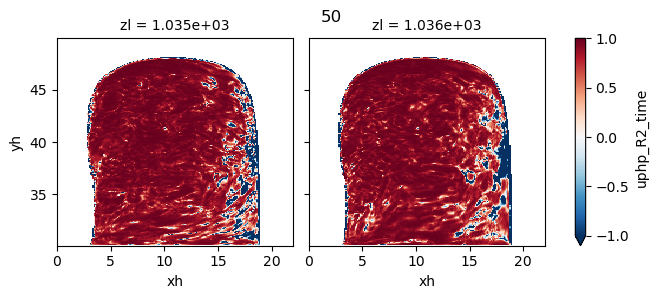

<Figure size 1200x550 with 0 Axes>

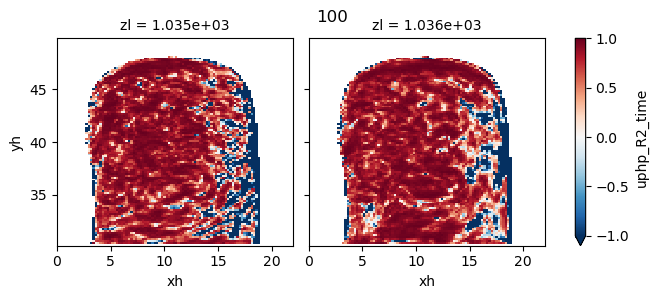

<Figure size 1200x550 with 0 Axes>

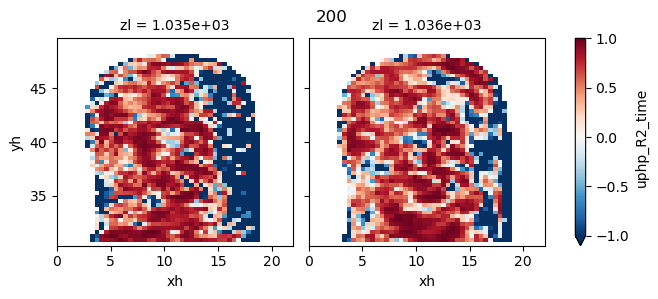

<Figure size 1200x550 with 0 Axes>

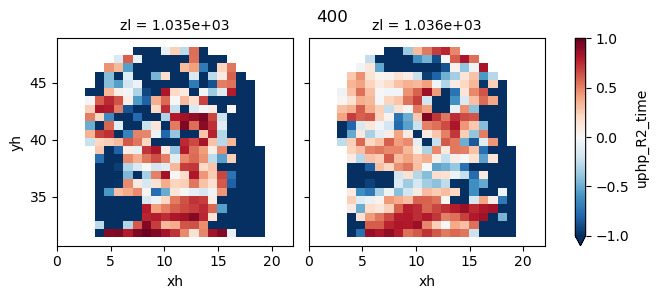

In [33]:
for scale in experiment_config_nondim['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval_nondim.eval_datatree.ml_dataset[exp][scale].uphp_R2_time.plot(col='zl', vmax=1)
    plt.suptitle(scale)

<Figure size 1200x550 with 0 Axes>

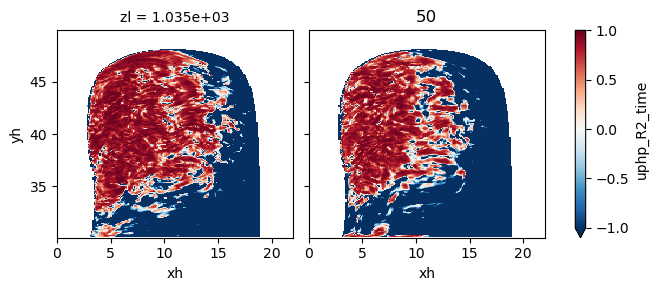

<Figure size 1200x550 with 0 Axes>

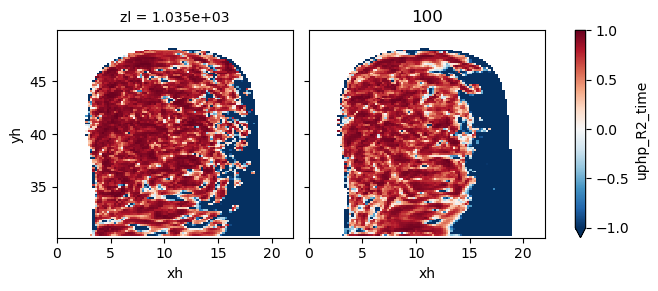

<Figure size 1200x550 with 0 Axes>

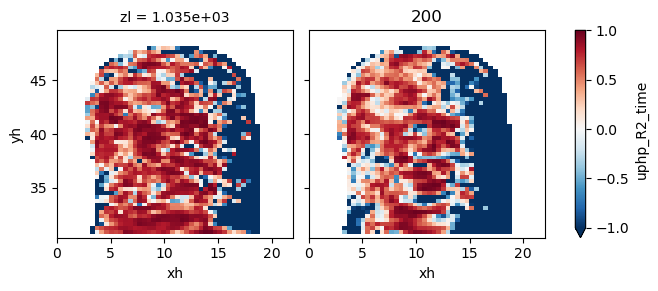

<Figure size 1200x550 with 0 Axes>

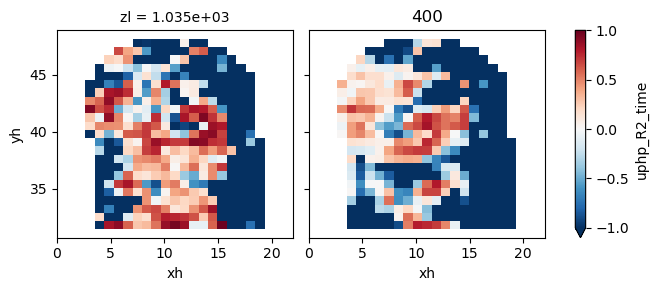

In [32]:
for scale in experiment_config_dim['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval_dim.eval_datatree.ml_dataset[exp][scale].uphp_R2_time.plot(col='zl', vmax=1)
    plt.title(scale)